In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [175]:
import random
random.seed(42)

In [195]:
# up to 3.5 ratings are considered as "like", above 3.5 as "don't like"
THRESHOLD = 3.5

In [176]:
DATA_PATH = "../ml-latest-small"

ratings = pd.read_csv(os.path.join(DATA_PATH, "ratings.csv"))
movies = pd.read_csv(os.path.join(DATA_PATH, "movies.csv"))
tags = pd.read_csv(os.path.join(DATA_PATH, "tags.csv"))

# Unconstrained Matrix Factorisation based Collaborative Filtering (week 7)

In [6]:
df_ecommerce= pd.read_json('../1_ecommerce.jsonl', lines=True)

# for each session, we will create a list of items that the user has clicked on, removing duplicates
clicks_items_list = []
carts_items_list = []
orders_items_list = []

for events in df_ecommerce.events:
    clicks = []
    carts = []
    orders = []
    for e in events:
        if e['type'] == 'clicks':
            clicks.append(e['aid'])
        if e['type'] == 'carts':
            carts.append(e['aid'])
        if e['type'] == 'orders':
            orders.append(e['aid'])

    clicks_items_list.append(list(clicks))
    carts_items_list.append(list(carts))
    orders_items_list.append(list(orders))

df_ecommerce['clicks'] = clicks_items_list
df_ecommerce['carts'] = carts_items_list
df_ecommerce['orders'] = orders_items_list
df = df_ecommerce.drop(columns=["events"], axis=1)

clicks_length = df_ecommerce['clicks'].apply(len)
carts_length = df_ecommerce['carts'].apply(len)
orders_length = df_ecommerce['orders'].apply(len)

# takes only the session with items length higher than 20
df_truncated = df[df['clicks'].apply(lambda x: len(x) > 10)]
df = df_truncated.copy()
# redefine index
df.reset_index(drop=True, inplace=True)

# Explode each column (clicks, carts, orders)
df_clicks = df[['session', 'clicks']].explode('clicks').rename(columns={'clicks': 'item'}).dropna(subset=['item'])
df_carts = df[['session', 'carts']].explode('carts').rename(columns={'carts': 'item'}).dropna(subset=['item'])
df_orders = df[['session', 'orders']].explode('orders').rename(columns={'orders': 'item'}).dropna(subset=['item'])

# Concatenate the exploded dataframes
df_concat = pd.concat([df_clicks, df_carts, df_orders])

# Create a new column for each category indicating whether the item is present in that category
df_concat['click'] = df_concat['item'].isin(df_clicks['item']).astype(int)
df_concat['cart'] = df_concat['item'].isin(df_carts['item']).astype(int)
df_concat['order'] = df_concat['item'].isin(df_orders['item']).astype(int)

# Drop duplicates based on session and item
df_concat = df_concat.drop_duplicates(subset=['session', 'item'])

In [7]:
def sgd_matrix_factorization(df, k=10, alpha=0.01, lambda_reg=0.1, num_epochs=20, w_click=1, w_cart=3, w_order=5, test_size=0.2, validation_size=0.1):
    # Map session (users) and items to consecutive indices
    users = {u: i for i, u in enumerate(df['session'].unique())}
    items = {i: j for j, i in enumerate(df['item'].unique())}

    num_users = len(users)
    num_items = len(items)

    # Initialize U, V, and biases
    U = np.random.rand(num_users, k)
    V = np.random.rand(num_items, k)
    b_u = np.zeros(num_users)
    b_i = np.zeros(num_items)
    b = 0  # Global bias

    # Create (u, i, r_ui) tuples for all interactions
    data = []

    # iter throw all the rows of the dataframe
    # and create a list of tuples (user, item, rating)
    # Assign ratings to interactions
    for _, row in df.iterrows():
        u = users[row['session']]
        i = items[row['item']]

        # if this user has perform an action on this item, we assign a rating based on the action
        # type starting from the most important one
        # (order > cart > click)
        if row['order'] > 0:
            r_ui = w_order
        elif row['cart'] > 0:
            r_ui = w_cart
        elif row['click'] > 0:
            r_ui = w_click
        else:
            continue  # Skip interactions with no recorded action

        data.append((u, i, r_ui))

    # Split the data into training, validation, and test sets
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=validation_size, random_state=42)

    # Compute global bias as the mean rating of the training set
    if train_data:
        b = np.mean([r for _, _, r in train_data])

    print("Datasets created! Starting training...")

    # Training using SGD
    losses = []
    val_losses = []

    for epoch in range(num_epochs):
        np.random.shuffle(train_data)  # Shuffle data to improve convergence
        total_loss = 0
        total_val_loss = 0

        U_temp = U.copy()
        V_temp = V.copy()

        # Training phase
        for u, i, r_ui in train_data:
            # Predict the rating using the current model parameters
            # b is the global bias, b_u[u] is the user bias, b_i[i] is the item bias
            pred = b + b_u[u] + b_i[i] + np.dot(U[u, :], V[i, :])

            # Calculate the error
            e_ui = r_ui - pred  # Error

            # Update biases
            # alpha is the learning rate, lambda_reg is the regularization parameter
            b_u[u] += alpha * (e_ui - lambda_reg * b_u[u])
            b_i[i] += alpha * (e_ui - lambda_reg * b_i[i])

            # Update latent factors using temporary matrices
            U_temp[u, :] += alpha * (e_ui * V[i, :] - lambda_reg * U[u, :])
            V_temp[i, :] += alpha * (e_ui * U[u, :] - lambda_reg * V[i, :])

            total_loss += e_ui ** 2  # Sum of squared errors
        total_loss /= len(train_data)
        total_loss = np.sqrt(total_loss)

        # Copy back updated matrices
        U = U_temp
        V = V_temp

        # Validation phase (calculate validation loss)
        for u, i, r_ui in val_data:
            pred = b + b_u[u] + b_i[i] + np.dot(U[u, :], V[i, :])
            e_ui = r_ui - pred  # Error
            total_val_loss += e_ui ** 2
        total_val_loss /= len(val_data)
        total_val_loss = np.sqrt(total_val_loss)

        # Append losses for the current epoch
        losses.append(total_loss)
        val_losses.append(total_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, RMSE Train Loss: {total_loss:.4f}, RMSE Val Loss: {total_val_loss:.4f}")

    # Test phase (calculate test loss)
    test_loss = 0
    for u, i, r_ui in test_data:
        pred = b + b_u[u] + b_i[i] + np.dot(U[u, :], V[i, :])
        e_ui = r_ui - pred  # Error
        test_loss += e_ui ** 2
    test_loss /= len(test_data)
    test_loss = np.sqrt(test_loss)

    print(f"Final Test RMSE: {test_loss:.4f}")

    return U, V, b_u, b_i, b, losses, val_losses, test_data

In [8]:
U, V, b_u, b_i, b, _, _, test_data = sgd_matrix_factorization(df_concat, k=5, alpha=0.001, num_epochs=1, w_click=1, w_order=2, w_cart=3)

Datasets created! Starting training...
Epoch 1/1, RMSE Train Loss: 1.5883, RMSE Val Loss: 1.5226
Final Test RMSE: 1.5211


In [9]:
df_test_data_mf = pd.DataFrame(test_data, columns=['session', 'item', 'rating_label'])
 
# Estrai gli indici in array NumPy
sessions = df_test_data_mf ['session'].values
items = df_test_data_mf ['item'].values
 
# Calcola le predizioni in maniera vettoriale:
# La formula è: pred = b + b_u[u] + b_i[i] + np.dot(U[u, :], V[i, :])
predicted_ratings = b + b_u[sessions] + b_i[items] + np.einsum('ij,ij->i', U[sessions], V[items])
 
# Crea il DataFrame delle predizioni copiando all_data e aggiungendo la colonna calcolata
df_predictions_mf = df_test_data_mf .copy()
df_predictions_mf['predicted'] = predicted_ratings
 
# Convert the predicted ratings to integers
df_predictions_mf['predicted'] = df_predictions_mf['predicted'].round().astype(int)
 
# Normalize the predicted ratings to the range [min_possible_rating, max_possible_rating]
df_predictions_mf['predicted'] = df_predictions_mf['predicted'].apply(lambda x: min(max(x, 1), 3))
df_predictions_mf

,session,item,rating_label,predicted
0,109434,114361,1,3
1,82622,188914,3,3
2,42492,40283,3,3
3,31592,230026,1,3
4,23208,115362,3,3
...,...,...,...,...
362389,52380,14256,2,3
362390,5881,69434,2,3
362391,91195,92264,1,3
362392,11304,66181,2,3


# Naive Bayes CF Model Based (Week6)

In [178]:
df_ratings = ratings.copy()

# df_ratings.loc[df_ratings['rating'] <= 2, 'rating_ordinal'] = "Don't like"
# df_ratings.loc[df_ratings['rating'] >= 4, 'rating_ordinal'] = "Like"
df_ratings['rating_ordinal'] = df_ratings['rating'].apply(
    lambda r: "Don't like" if r <= THRESHOLD else ("Like" if r > THRESHOLD else None)
)

ratings_ordinals = df_ratings['rating_ordinal'].unique()
all_films = df_ratings["movieId"].unique()

In [181]:
# Keep only rows with known ordinal ratings ("Like" or "Don't like")
df_known = df_ratings.dropna(subset=['rating_ordinal'])

In [194]:
df_known.head()

,userId,movieId,rating,timestamp,rating_ordinal
0,1,1,4.0,964982703,Like
1,1,3,4.0,964981247,Like
2,1,6,4.0,964982224,Like
3,1,47,5.0,964983815,Like
4,1,50,5.0,964982931,Like


In [183]:
df_known['rating_ordinal'].value_counts()

rating_ordinal
Don't like    52256
Like          48580
Name: count, dtype: int64

In [184]:
# Keep only rows with known ordinal ratings ("Like" or "Don't like")
# df_known = df_ratings.dropna(subset=['rating_ordinal'])

# Use stratified sampling to ensure class balance ("Like" vs "Don't like") in the test set
df_train, df_test = train_test_split(
    df_known,
    test_size=0.01,
    random_state=42,
    stratify=df_known['rating_ordinal']
)

# Create a user-movie rating matrix using only the training data
df_train_user_movie = df_train.pivot(index='userId', columns='movieId', values='rating_ordinal')

# Prepare the test set as a list of (userId, movieId, rating_ordinal) for evaluation
df_test = df_test[['userId', 'movieId', 'rating_ordinal']]

In [188]:
df_test['rating_ordinal'].value_counts()

rating_ordinal
Don't like    523
Like          486
Name: count, dtype: int64

In [187]:
df_train_user_movie.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,Like,NaN,Like,NaN,NaN,Like,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Like,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,Like,Like,Don't like,Like,Like,Like,Don't like,NaN,Don't like,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Like,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,Like,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Don't like,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [209]:
def test_naive_cf_model_based(df_test, df_train_user_movie):

    df_predictions = df_test.copy()

    for idx, row in enumerate(df_predictions.itertuples()):
        userId = row.userId
        movieId = row.movieId

        # Film visti dall'utente, dai dati di TRAIN
        try:
            films_seen = df_train_user_movie.loc[userId].dropna().index
        except KeyError:
            # Utente non presente nel train (cold start) → skip
            continue

        category_probs = {}

        for category in ratings_ordinals:
            df_current_movie = df_train[(df_train['movieId'] == movieId)]
            df_current_movie_category = df_current_movie[(df_current_movie['rating_ordinal'] == category)]

            if len(df_current_movie) == 0:
                continue

            users_with_category = df_current_movie_category['userId'].unique()

            p_cat = len(df_current_movie_category) / len(df_current_movie)
            probs = [p_cat]

            for film_seen in films_seen:
                try:
                    assigned_rating = df_train_user_movie.loc[userId, film_seen]
                except KeyError:
                    continue  # Film non presente per quell’utente

                df_seen_movie = df_train[df_train['movieId'] == film_seen]
                df_seen_movie_filtered = df_seen_movie[df_seen_movie['userId'].isin(users_with_category)]
                df_seen_movie_same_rating = df_seen_movie_filtered[df_seen_movie_filtered['rating_ordinal'] == assigned_rating]

                if len(df_seen_movie_filtered) == 0:
                    continue

                p_cond = len(df_seen_movie_same_rating) / len(df_seen_movie_filtered)
                probs.append(p_cond)

            category_probs[category] = np.prod(probs)

        if category_probs:
            predicted = max(category_probs.items(), key=lambda x: x[1])[0]            
            df_predictions.loc[(df_predictions['userId'] == userId) & (df_predictions['movieId'] == movieId), 'predicted'] = predicted

        if idx % 50 == 0:
            print(f"Processed {idx}/{len(df_predictions)}")

    return df_predictions

In [235]:
df_predictions = test_naive_cf_model_based(df_test, df_train_user_movie)

Processed 0/1009
Processed 50/1009
Processed 100/1009
Processed 150/1009
Processed 200/1009
Processed 250/1009
Processed 300/1009
Processed 350/1009
Processed 400/1009
Processed 450/1009
Processed 500/1009
Processed 550/1009
Processed 600/1009
Processed 650/1009
Processed 700/1009
Processed 750/1009
Processed 800/1009
Processed 850/1009
Processed 900/1009
Processed 950/1009
Processed 1000/1009


In [244]:
df_predictions.head(10)

,userId,movieId,rating_ordinal,predicted,rating_label,pred_label
61650,408,54648,Like,Like,1,1.0
84770,549,2028,Like,Don't like,1,0.0
49000,318,165,Don't like,Like,0,1.0
48189,312,3793,Don't like,Like,0,1.0
64643,414,54286,Like,Like,1,1.0
15949,104,110,Don't like,Like,0,1.0
20051,132,2023,Don't like,Like,0,1.0
22134,146,2805,Don't like,Like,0,1.0
56059,370,4878,Like,Like,1,1.0
18486,117,745,Like,Like,1,1.0


In [246]:
df_predictions['predicted'].value_counts()

predicted
Like          960
nan            28
Don't like     21
Name: count, dtype: int64

In [252]:
# Skipping the NaN values (we have some predictions that are nan)
df_predictions = df_predictions[df_predictions['predicted'] != "nan"]

In [253]:
# convert the predicted ratings to integers
df_predictions['rating_label'] = df_predictions['rating_ordinal'].map({
    "Don't like": 0,
    "Like": 1
})

df_predictions['pred_label'] = df_predictions['predicted'].map({
    "Don't like": 0,
    "Like": 1
})

In [255]:
df_predictions.head()

,userId,movieId,rating_ordinal,predicted,rating_label,pred_label
61650,408,54648,Like,Like,1,1
84770,549,2028,Like,Don't like,1,0
49000,318,165,Don't like,Like,0,1
48189,312,3793,Don't like,Like,0,1
64643,414,54286,Like,Like,1,1


In [256]:
print(classification_report(df_predictions['rating_label'], df_predictions['pred_label']))

              precision    recall  f1-score   support

           0       0.67      0.03      0.05       504
           1       0.49      0.99      0.65       477

    accuracy                           0.49       981
   macro avg       0.58      0.51      0.35       981
weighted avg       0.58      0.49      0.35       981


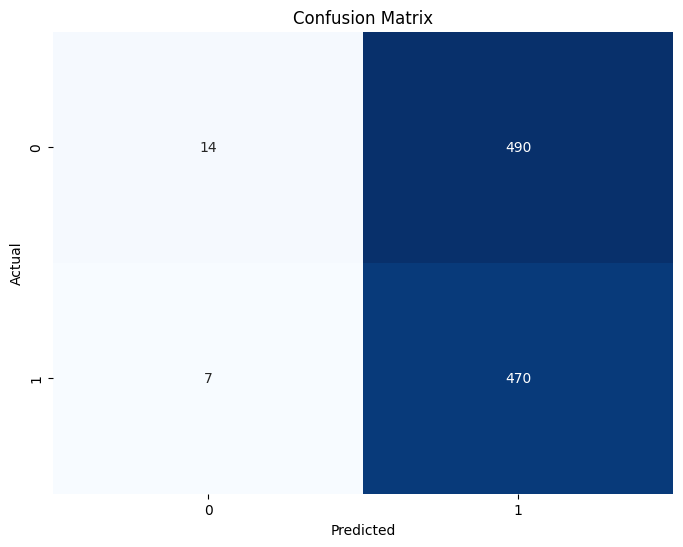

In [257]:
confusion_matrix = pd.crosstab(df_predictions['rating_label'], df_predictions['pred_label'], rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Bayes Classification Content-based (week 8)

In [258]:
## Preprocess Movie Metadata
tags_agg = tags.copy().groupby("movieId")["tag"].apply(lambda x: " ".join(x)).reset_index()
movies_df = movies.copy().merge(tags_agg, on="movieId", how="left")
movies_df["tag"] = movies_df["tag"].fillna("")

#### 1. User-Specific Naive Bayes Recommender

In [259]:
# Clean the title by removing the year in parentheses
def clean_title(title):
    return re.sub(r'\s*\(\d{4}\)', '', title)

metadata = movies_df[["movieId", "title", "genres"]]
metadata.loc[:, 'title'] = metadata['title'].apply(clean_title)

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(metadata['genres'].str.split('|'))
# Create a DataFrame with the encoded genres
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
# Concatenate the original metadata with the encoded genres
metadata = pd.concat([metadata[['movieId', 'title']], genres_df], axis=1)

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')

# Create a preprocessor that transforms the movie metadata:
# - Applies TF-IDF vectorization to the cleaned 'title' column to extract textual features.
# - Passes through the binary genre columns (already transformed by MultiLabelBinarizer).
# - Drops any remaining columns that are not explicitly selected.
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf, 'title'),
        ('genres', 'passthrough', genres_df.columns)
    ],
    remainder='drop'
)

In [260]:
def predict_single_movie(user_id, movie_id, ratings_train):
    ratings = ratings_train.copy()

    # Step 1: Prepare user data
    user_ratings = ratings[ratings['userId'] == user_id]
    user_data = pd.merge(user_ratings, metadata, on='movieId')

    # Step 2: Create binary labels
    user_data['label'] = user_data['rating'].apply(lambda r: 1 if r >= 4 else (0 if r <= 2 else None))
    user_data = user_data.dropna(subset=['label'])
    user_data['label'] = user_data['label'].astype(int)

    if user_data.empty:
        print("User has insufficient data.")
        return None

    # Step 3: Train the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', MultinomialNB())
    ])

    X_train = user_data.drop(columns=['userId', 'rating', 'label', 'timestamp', 'rating_ordinal'])
    y_train = user_data['label']

    pipeline.fit(X_train, y_train)

    # Step 4: Check if the movie has already been watched
    if movie_id in user_ratings['movieId'].values:
        print("The movie has already been watched by the user.")
        return None

    # Step 5: Extract features of the requested movie
    movie_row = metadata[metadata['movieId'] == movie_id]

    if movie_row.empty:
        print("Movie ID not found in the metadata.")
        return None

    input_cols = list(X_train.columns)
    movie_features = movie_row[input_cols]

    # Step 6: Predict the probability of liking the movie
    probs = pipeline.predict_proba(movie_features)[0]  # P(liked | features)
    if len(probs) < 2:
        print(f"The model for user {user_id} has seen only one class (not like/like).")
        return None
    else:
        prob = probs[1]

    return "Like" if prob >= 0.5 else "Don't like"

In [261]:
chosen_user = random.choice(ratings['userId'].unique())
chosen_film = random.choice(metadata['movieId'].unique())

predict_single_movie(user_id=chosen_user, movie_id=chosen_film, ratings_train=df_train)

'Like'

#### 2. Global Content-Based Recommender (Single Model for All Users)

In [262]:
metadata_with_tags = metadata.merge(movies_df[["movieId", "tag"]], on='movieId', how='left')

preprocessor_global = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf, 'title'),
        ('genres', 'passthrough', genres_df.columns),
        ('tfidf_tag', tfidf, 'tag')
    ],
    remainder='drop'
)

In [263]:
def train_global_model(ratings_train):
    ratings = ratings_train.copy()
    # Step 1: Prepare data
    data = pd.merge(ratings, metadata_with_tags, on='movieId')

    # Step 2: Create binary labels
    data['label'] = data['rating'].apply(lambda r: 1 if r >= 4 else (0 if r <= 2 else None))
    data = data.dropna(subset=['label'])
    data['label'] = data['label'].astype(int)

    # Step 3: Train the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor_global),
        ('classifier', MultinomialNB())
    ])

    X = data.drop(columns=['userId', 'movieId', 'rating', 'label', 'timestamp', 'rating_ordinal'])
    y = data['label']

    model = pipeline.fit(X, y)
    return model, X.columns

model_global, train_columns = train_global_model(df_train)

def recommend_global(user_id, movie_id, ratings_train):
    ratings = ratings_train.copy()

    # Step 4: Check if the movie has already been watched
    user_ratings = ratings[ratings['userId'] == user_id]
    if movie_id in user_ratings['movieId'].values:
        print("The movie has already been watched by the user.")
        return None

    # Step 5: Extract features of the requested movie
    movie_row = metadata_with_tags[metadata_with_tags['movieId'] == movie_id]

    if movie_row.empty:
        print("Movie ID not found in the metadata.")
        return None
    movie_features = movie_row[train_columns]

    # Step 6: Predict the probability of liking the movie
    probs = model_global.predict_proba(movie_features)[0]  # P(liked | features)
    if len(probs) < 2:
        print(f"The model for user {user_id} has seen only one class (not like/like).")
        return None
    else:
        prob = probs[1]

    return "Like" if prob >= 0.5 else "Don't like"

In [264]:
recommend_global(user_id=chosen_user, movie_id=chosen_film, ratings_train=df_train)

'Like'

In [265]:
def test_naive_cf_content_based():
    for idx, row in enumerate(df_predictions.itertuples()):
        userId = row.userId
        movieId = row.movieId

        pred_user = predict_single_movie(userId, movieId, ratings_train=df_train)
        pred_global = recommend_global(userId, movieId, ratings_train=df_train)
        
        df_predictions.loc[(df_predictions['userId'] == userId) & (df_predictions['movieId'] == movieId), 'pred_user'] = pred_user
        df_predictions.loc[(df_predictions['userId'] == userId) & (df_predictions['movieId'] == movieId), 'pred_global'] = pred_global

In [266]:
test_naive_cf_content_based()

The model for user 435 has seen only one class (not like/like).
The model for user 402 has seen only one class (not like/like).
The model for user 507 has seen only one class (not like/like).
The model for user 348 has seen only one class (not like/like).
The model for user 425 has seen only one class (not like/like).
The model for user 417 has seen only one class (not like/like).
The model for user 475 has seen only one class (not like/like).
The model for user 586 has seen only one class (not like/like).
The model for user 150 has seen only one class (not like/like).
The model for user 586 has seen only one class (not like/like).
The model for user 43 has seen only one class (not like/like).
The model for user 169 has seen only one class (not like/like).
The model for user 169 has seen only one class (not like/like).
The model for user 440 has seen only one class (not like/like).
The model for user 49 has seen only one class (not like/like).
The model for user 93 has seen only one cl

In [267]:
df_predictions.dropna(subset=['pred_user', 'pred_global'], inplace=True)

In [268]:
df_predictions['pred_user_label'] = df_predictions['pred_user'].map({
    "Don't like": 0,
    "Like": 1
})

df_predictions['pred_global_label'] = df_predictions['pred_global'].map({
    "Don't like": 0,
    "Like": 1
})

In [269]:
df_predictions.head()

,userId,movieId,rating_ordinal,predicted,rating_label,pred_label,pred_user,pred_global,pred_user_label,pred_global_label
61650,408,54648,Like,Like,1,1,Like,Like,1,1
84770,549,2028,Like,Don't like,1,0,Like,Like,1,1
49000,318,165,Don't like,Like,0,1,Like,Like,1,1
48189,312,3793,Don't like,Like,0,1,Like,Like,1,1
64643,414,54286,Like,Like,1,1,Like,Like,1,1


In [270]:
print(classification_report(df_predictions['rating_label'], df_predictions['pred_label']))

              precision    recall  f1-score   support

           0       0.71      0.02      0.05       492
           1       0.48      0.99      0.64       442

    accuracy                           0.48       934
   macro avg       0.59      0.51      0.35       934
weighted avg       0.60      0.48      0.33       934


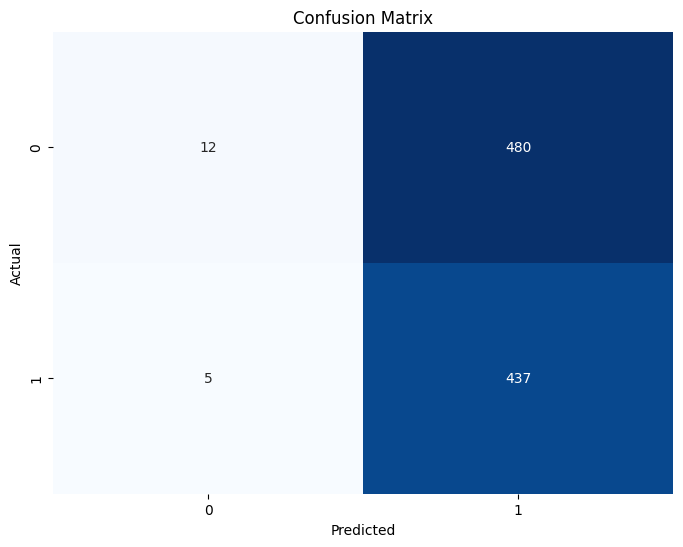

In [271]:
confusion_matrix = pd.crosstab(df_predictions['rating_label'], df_predictions['pred_label'], rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Evaluation

In [272]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc
from scipy.stats import spearmanr

In [283]:
def evaluate_accuracy(df, col):
    acc = accuracy_score(df['rating_label'], df[col])
    precision = precision_score(df['rating_label'], df[col], zero_division=0, average='binary' if df['rating_label'].nunique() == 2 else 'macro')
    recall = recall_score(df['rating_label'], df[col], zero_division=0, average='binary' if df['rating_label'].nunique() == 2 else 'macro')
    f1 = f1_score(df['rating_label'], df[col], zero_division=0 , average='binary' if df['rating_label'].nunique() == 2 else 'macro')
    print("------------------------------------------")
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print("------------------------------------------")

In [274]:
def long_tail_analysis(df, col, itemCol):
    # Calculate the frequency of each movie based on its occurrence
    movie_counts = df[itemCol].value_counts()

    # Define the threshold at the 75th percentile to separate head vs. long tail
    threshold = movie_counts.quantile(0.75)

    # Add a 'popularity' column based on item frequency
    df['popularity'] = df[itemCol].map(
        lambda x: 'long_tail' if movie_counts[x] <= threshold else 'head'
    )

    # Compute absolute error for each row
    df['error'] = abs(df['rating_label'] - df[col])
   
    # Group by 'popularity' and calculate the average error
    error_by_popularity = df.groupby('popularity')['error'].mean()
   
    # Print the results
    print("Mean Absolute Error by Popularity:")
    print(error_by_popularity)
    print("------------------------------------------")

    # Visualize the distribution of item frequencies
    plt.figure(figsize=(10, 6))
    plt.hist(movie_counts, bins=50, alpha=0.7, color='skyblue', edgecolor='gray')
    plt.axvline(threshold, color='red', linestyle='--', linewidth=2,
                label=f"Threshold (75th percentile): {threshold:.0f}")
    plt.xlabel("Number of ratings per item")
    plt.ylabel("Frequency")
    plt.title("Distribution of ratings per item (Long Tail)")
    plt.legend()
    plt.show()
       
    # Print the number of items in each popularity group
    long_tail_count = (movie_counts < threshold).sum()
    head_count = (movie_counts >= threshold).sum()
    print(f"Number of items in long tail: {long_tail_count}")
    print(f"Number of items in head: {head_count}")
   
    return error_by_popularity

In [359]:
def error_by_popularity(df, k, col):
    # count number of ratings per movie
    movie_counts = df['movieId'].value_counts()

    # sort the movies by number of ratings
    movie_counts = movie_counts.sort_values(ascending=False)

    # Select the k most popular movies
    most_popular_movies = movie_counts.head(k).index

    # Filter the dataset
    df_most_popular = df[df['movieId'].isin(most_popular_movies)].copy()

    # Compute absolute error
    df_most_popular['abs_error'] = abs(df_most_popular['rating_label'] - df_most_popular[col])

    top_movie_counts = movie_counts.head(k)
    
    # Plot 1: Rating label distribution for the same movies
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_movie_counts.index.astype(str), y=top_movie_counts.values)
    plt.xticks(rotation=45)
    plt.xlabel("Movie ID")
    plt.ylabel("Number of Ratings")
    plt.title(f"Top {k} Most Rated Movies")
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Mean absolute error for each of the top 10 movies
    error_df = df_most_popular.groupby('movieId').agg({'abs_error': 'mean'}).reset_index()

    df_ordered = error_df.set_index('movieId').loc[most_popular_movies].reset_index()
    plt.figure(figsize=(10, 4))
    sns.barplot(data=df_ordered, x=df_ordered['movieId'].astype(str), y='abs_error', color='cornflowerblue')
    plt.title(f"Mean Absolute Error for the {k} Most Popular Movies")
    plt.xlabel("Movie ID")
    plt.ylabel("Mean Absolute Error")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [361]:
# error_by_popularity(df_predictions, 20, "pred_label")

In [275]:
def error_by_genre(df, col):
    df_with_genre = df.merge(movies[['movieId', 'genres']], on='movieId', how='left')
    
    # Compute absolute error
    df_with_genre['abs_error'] = abs(df_with_genre['rating_label'] - df_with_genre[col])

    # Expand genres from pipe-separated string to individual rows
    df_genres_expanded = df_with_genre.copy()
    df_genres_expanded['genres'] = df_genres_expanded['genres'].str.split('|')
    df_genres_expanded = df_genres_expanded.explode('genres')

    # Compute mean error per genre
    genre_errors = df_genres_expanded.groupby('genres')['abs_error'].mean().sort_values()

    # Plot the result
    plt.figure(figsize=(10, 4))
    genre_errors.plot(kind='bar', color='cornflowerblue')
    plt.title("Mean Absolute Error by Movie Genre")
    plt.ylabel("Mean Absolute Error")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [276]:
def evaluate_correlation(df, score_col):
    corr_spear = spearmanr(df['rating_label'], df[score_col])
    print(f"Spearman correlation: {corr_spear.correlation:.3f}, p-value: {corr_spear.pvalue:.3f}")

In [277]:
def evaluate_topk(y_true, y_scores, topk_list=[5, 10, 20]):
    results = []
    for k in topk_list:
        idx = np.argsort(-y_scores)[:k]
        y_pred_topk = np.zeros_like(y_true)
        y_pred_topk[idx] = 1

        p = precision_score(y_true, y_pred_topk, zero_division=0, average='binary' if len(np.unique(y_true)) == 2 else 'macro')
        r = recall_score(y_true, y_pred_topk, zero_division=0, average='binary' if len(np.unique(y_true)) == 2 else 'macro')
        f1 = f1_score(y_true, y_pred_topk, zero_division=0, average='binary' if len(np.unique(y_true)) == 2 else 'macro')
        results.append({'topk': k, 'precision': p, 'recall': r, 'f1': f1})
    return pd.DataFrame(results)


In [278]:
def plot_pr_roc(y_true, y_scores, model_name="model"):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    fpr, tpr, _ = roc_curve(y_true, y_scores)

    pr_auc = auc(recall, precision)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f'PR AUC={pr_auc:.2f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({model_name})")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC Curve ({model_name})")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [279]:
def random_recommender_benchmark(df, topk_list=[5, 10, 20]):
    rand_scores = np.random.rand(len(df))
    df['random_score'] = rand_scores

    print("Random Recommender Evaluation")
    display(evaluate_topk(df['rating_label'].values, df['random_score'].values, topk_list))
    plot_pr_roc(df['rating_label'].values, df['random_score'].values, "Random Recommender")


Evaluation for Naive CF
------------------------------------------
Accuracy: 0.481
Precision: 0.477
Recall: 0.989
F1 Score: 0.643
------------------------------------------


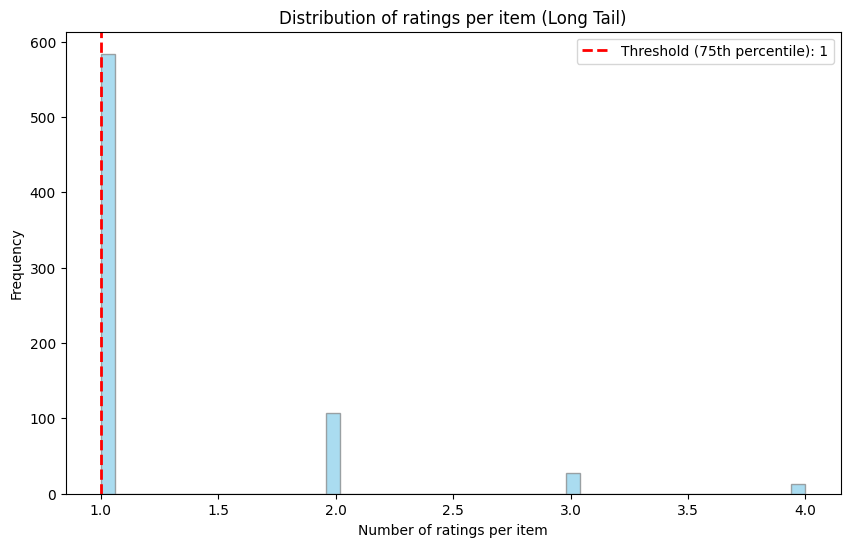

Number of items in long tail: 0
Number of items in head: 732


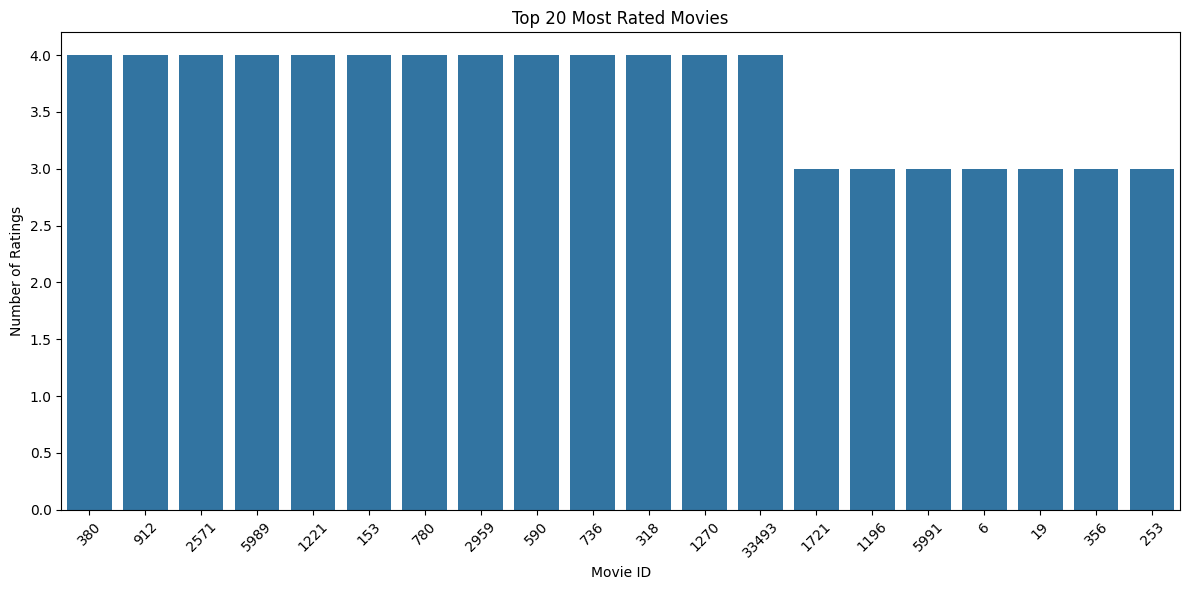

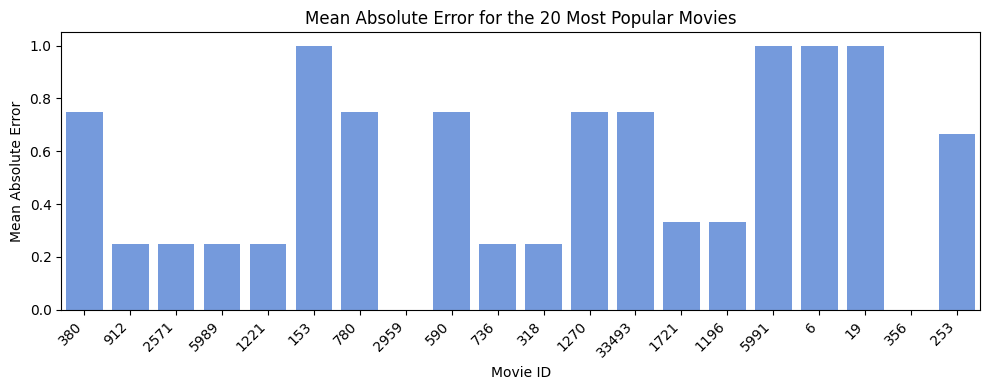

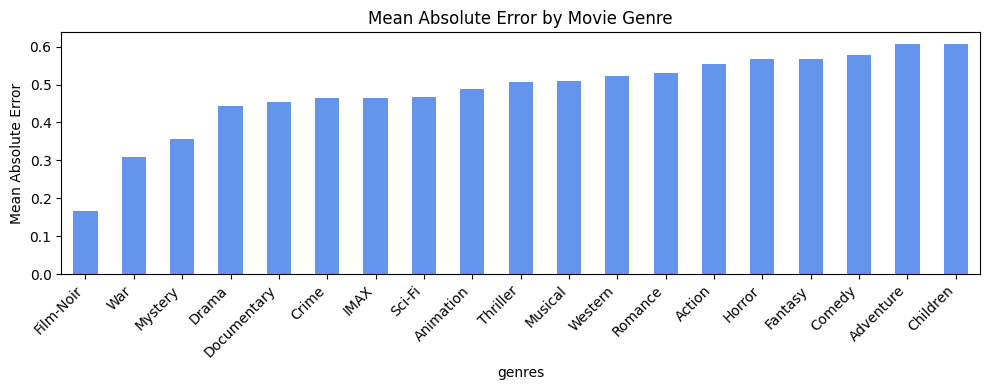

Spearman correlation: 0.049, p-value: 0.136


,topk,precision,recall,f1
0,5,0.2,0.002262,0.004474
1,10,0.4,0.009050,0.017699
2,20,0.3,0.013575,0.025974


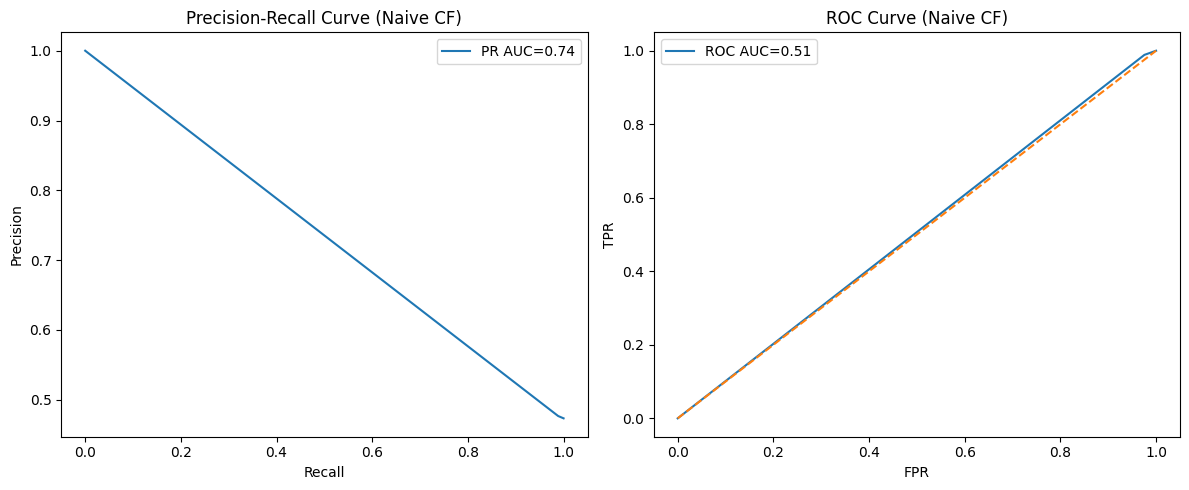

Evaluation for User-based CF
------------------------------------------
Accuracy: 0.588
Precision: 0.536
Recall: 0.959
F1 Score: 0.688
------------------------------------------


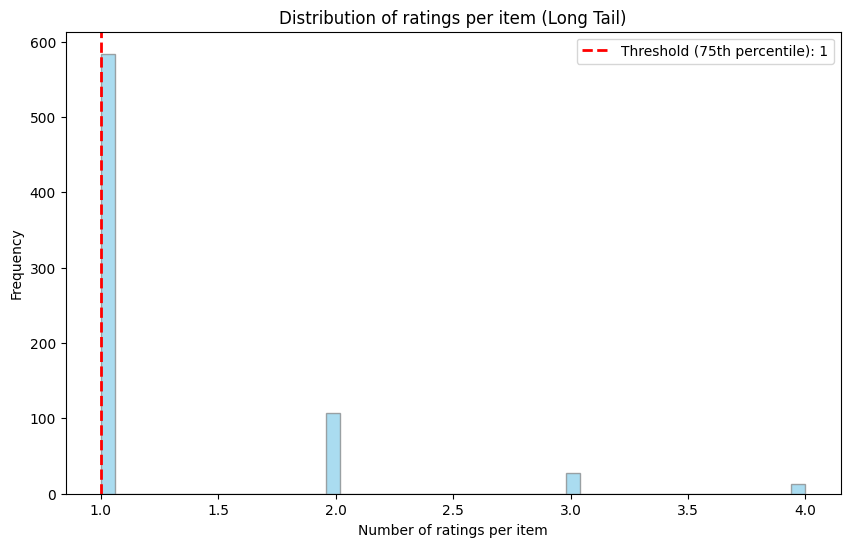

Number of items in long tail: 0
Number of items in head: 732


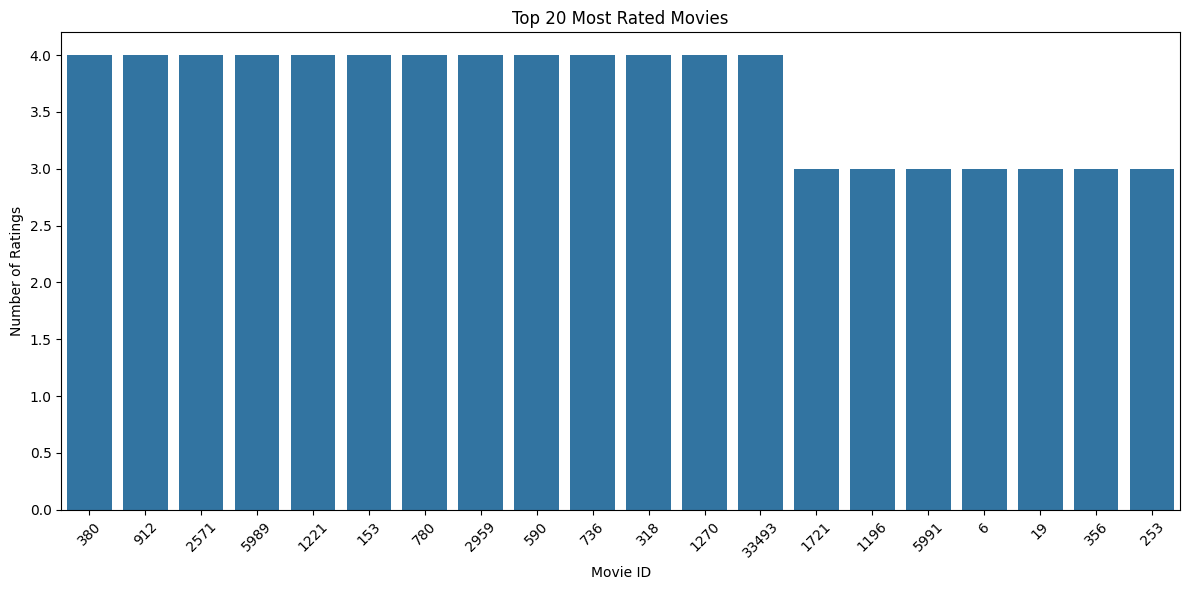

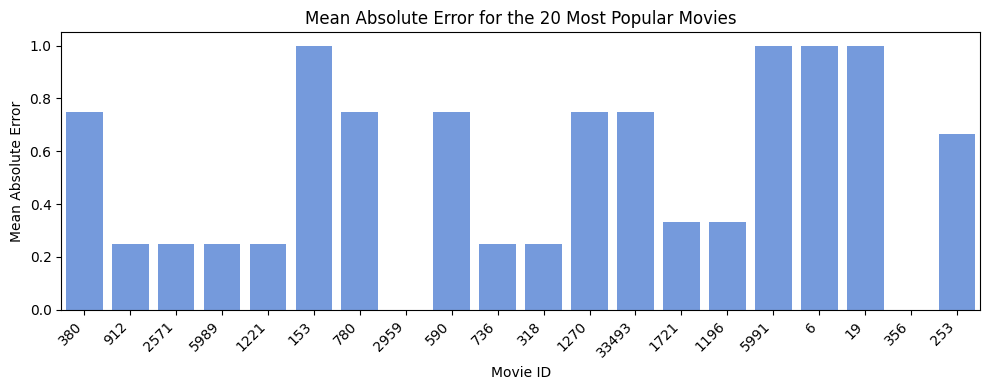

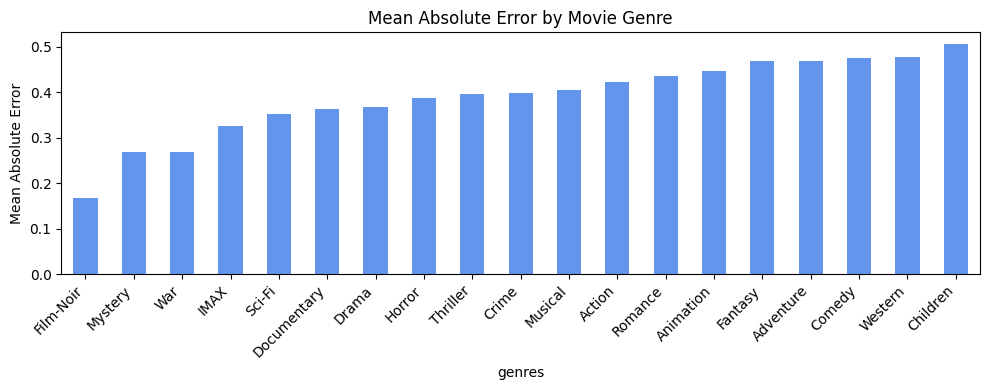

Spearman correlation: 0.296, p-value: 0.000


,topk,precision,recall,f1
0,5,1.0,0.011312,0.022371
1,10,0.9,0.020362,0.039823
2,20,0.6,0.027149,0.051948


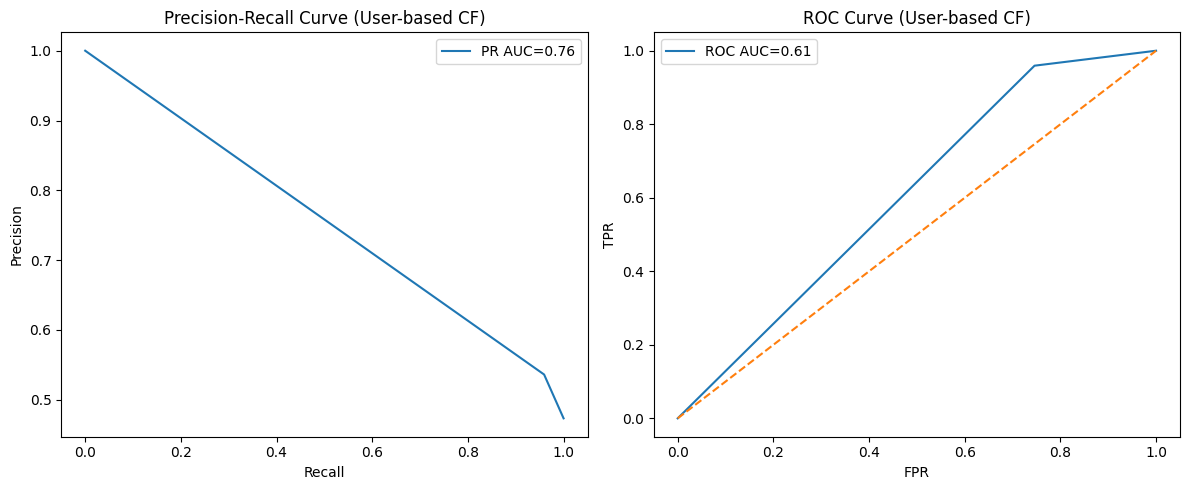

Evaluation for Global CF
------------------------------------------
Accuracy: 0.561
Precision: 0.521
Recall: 0.907
F1 Score: 0.662
------------------------------------------


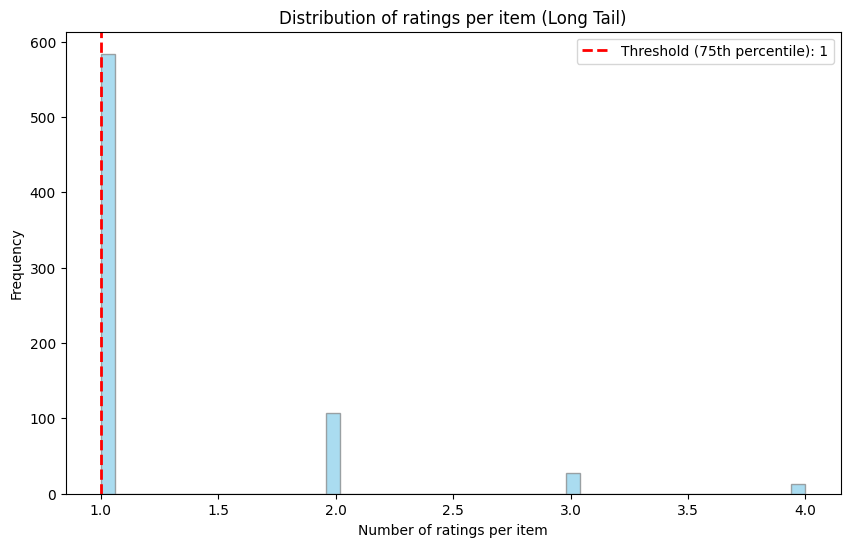

Number of items in long tail: 0
Number of items in head: 732


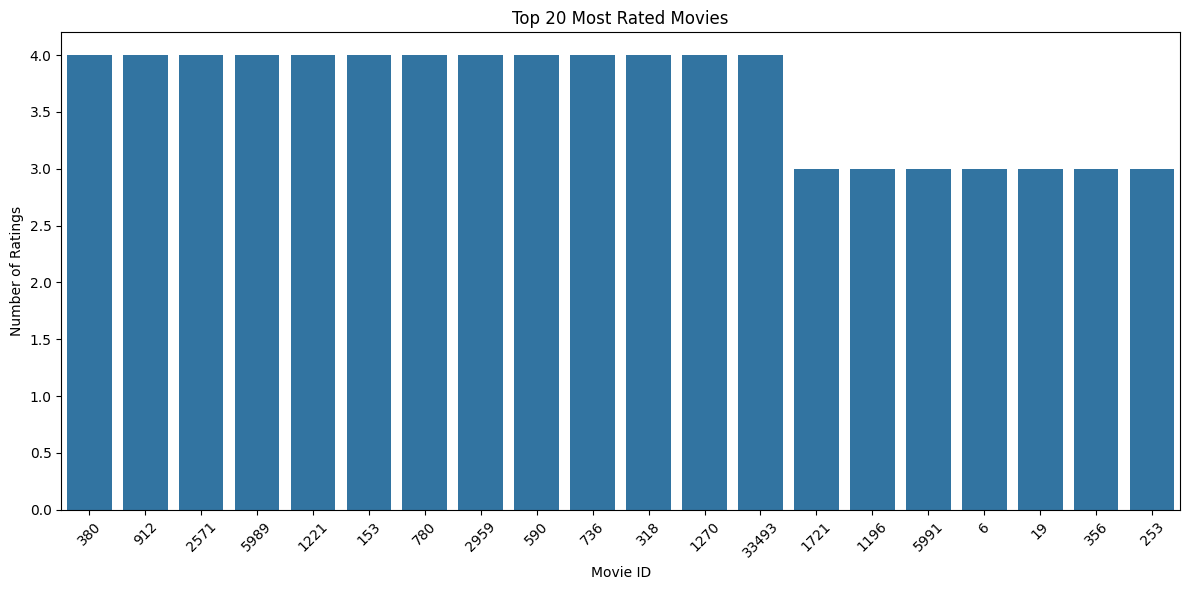

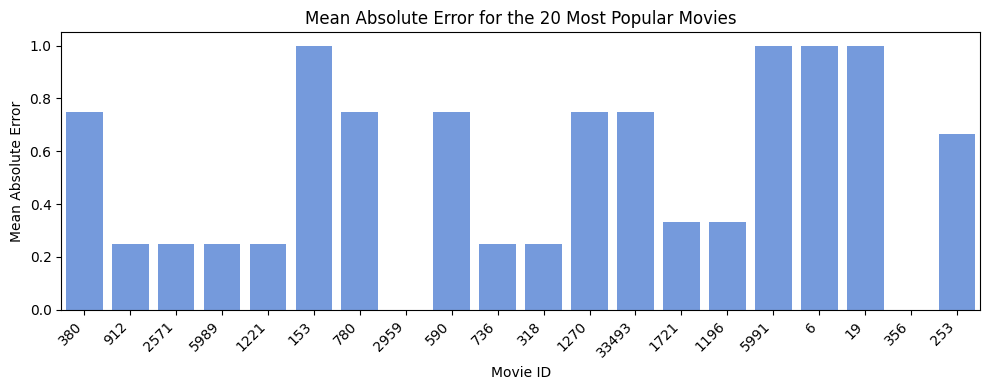

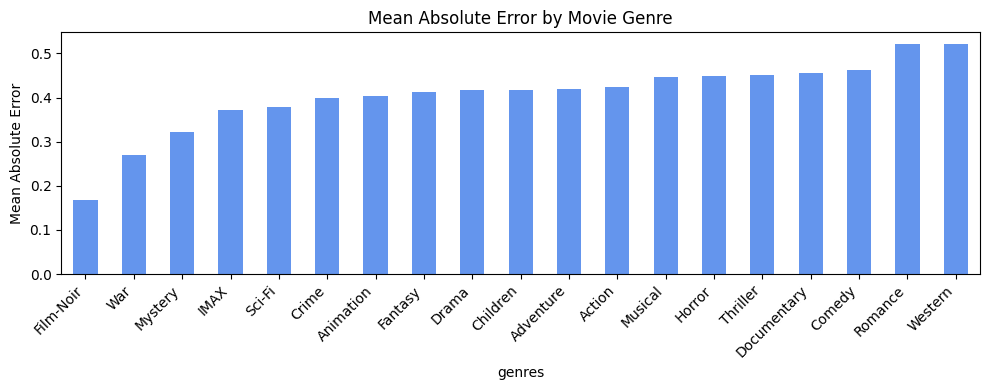

Spearman correlation: 0.206, p-value: 0.000


,topk,precision,recall,f1
0,5,0.60,0.006787,0.013423
1,10,0.60,0.013575,0.026549
2,20,0.55,0.024887,0.047619


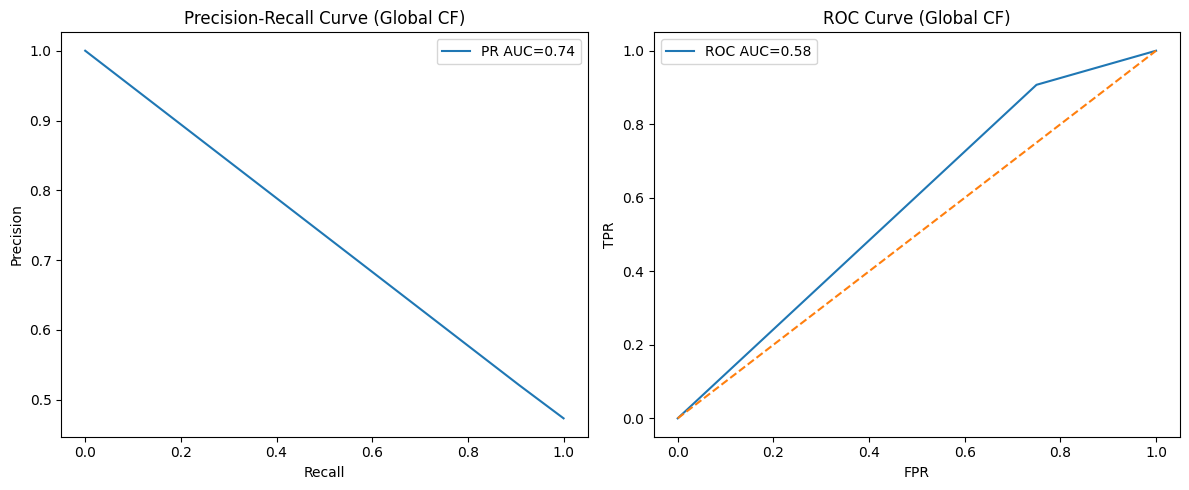

Random Recommender Evaluation


,topk,precision,recall,f1
0,5,0.60,0.006787,0.013423
1,10,0.60,0.013575,0.026549
2,20,0.45,0.020362,0.038961


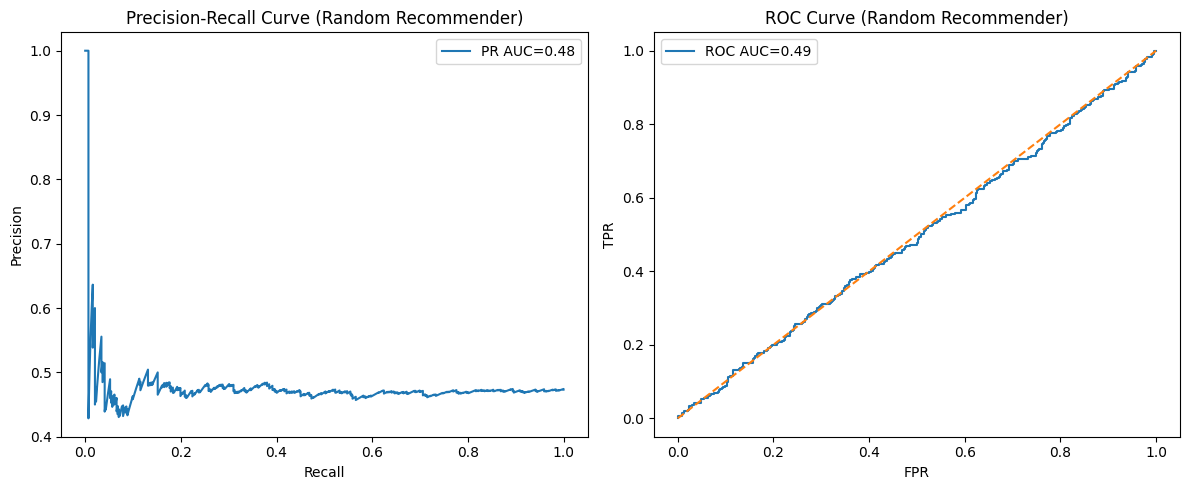

In [362]:
col = {
    'pred_label': 'Naive CF',
    'pred_user_label': 'User-based CF',
    'pred_global_label': 'Global CF'
}

# Evaluate all the models
for c in col.keys():
    print(f"Evaluation for {col[c]}")
    evaluate_accuracy(df_predictions, c)
    long_tail_analysis(df_predictions, c, 'movieId')
    error_by_popularity(df_predictions, 20, "pred_label")
    error_by_genre(df_predictions, c)
    evaluate_correlation(df_predictions, c)
    display(evaluate_topk(df_predictions['rating_label'].values, df_predictions[c].values))
    plot_pr_roc(df_predictions['rating_label'].values, df_predictions[c].values, col[c])

random_recommender_benchmark(df_predictions)

Evaluation for Matrix Factorization
accuracy=0.368, precision=0.231, recall=0.359, f1=0.247


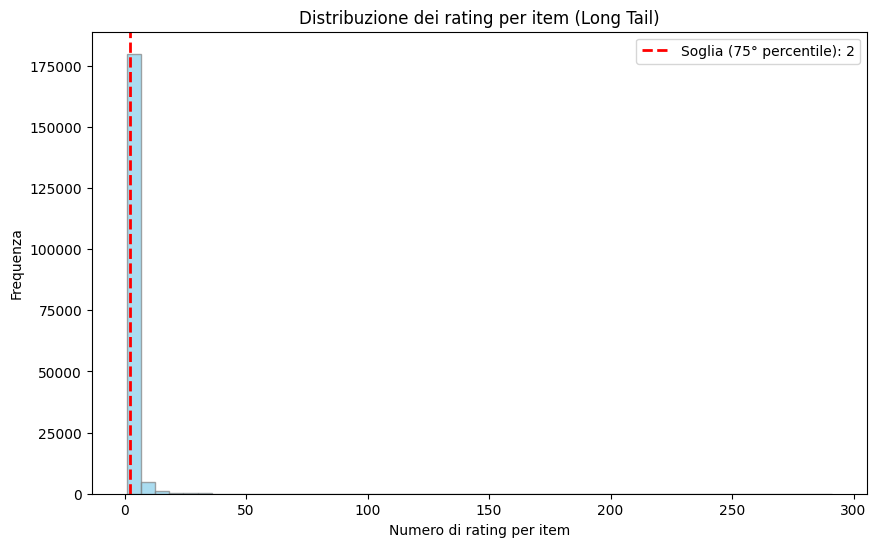

Numero di item in long tail: 129501
Numero di item in head: 57365
Spearman correlation: 0.018, p-value: 0.000


,topk,precision,recall,f1
0,5,0.100,0.000003,0.000007
1,10,0.150,0.000010,0.000020
2,20,0.125,0.000016,0.000033


In [ ]:
print("Evaluation for Matrix Factorization")
evaluate_accuracy(df_predictions_mf, 'predicted')
long_tail_analysis(df_predictions_mf, 'predicted', 'item')
evaluate_correlation(df_predictions_mf, 'predicted')
display(evaluate_topk(df_predictions_mf['rating_label'].values, df_predictions_mf['predicted'].values))